# Imports and data

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from ESN.ESN import *
from Helper.utils import nrmse
import os
from MackeyGlass.MackeyGlassGenerator import run
import time
import seaborn as sns

sns.set_style('whitegrid')
sns.despine()
sns.set_context('notebook', font_scale=1.5)

USE_NEW_DATA = False

if USE_NEW_DATA:
    data = np.array(run(16100, beta=0.3, gamma=0.2)).reshape(-1, 1)
else:
    data = np.array(run(16100)).reshape(-1, 1)
    
split = 14100
split_test = 15100
X_train = np.array(data[:split-1])
y_train = np.array(data[1:split])

X_valid = np.array(data[split-1:split_test-1])
y_valid = np.array(data[split:split_test])

X_test = np.array(data[split_test-1:-1])
y_test = np.array(data[split_test:])

data_mean = np.mean(data)
print(len(X_train) + len(X_valid) + len(X_test))

if 0:
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 12))
    ax1.plot(range(1000), data[:1000])
    ax2.plot(range(1000), data_new[:1000])
    plt.show()

    print(np.sum((data - data_new)**2))

16099


# View best LCESN grid-search results

In [3]:
res_files = os.listdir('Results/LCESN')
#print(res_files)

results = pkl.load(open('Results/LCESN/Tue-Mar-20-16:54:59-2018.p'))
results_list = results.items()
print(len(results_list))
results_list = sorted(results_list, key=lambda x: np.mean(x[1]))

for k, v in results_list[:3]:
    print(k)
    print(v)

512

        num_res: 10
res_sizes:[200 200 200 200 200 200 200 200 200 200]
echo_params:[0.84999999999999998, 0.81111111111111112, 0.77222222222222214, 0.73333333333333328, 0.69444444444444442, 0.65555555555555556, 0.6166666666666667, 0.57777777777777772, 0.53888888888888886, 0.5]
input_scales:[0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001, 0.20000000000000001]
spectral_scales:[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
        regulariser: 0.000100
[0.017733589389141727, 0.0054939505444227066, 0.086991286698266362]

        num_res: 10
res_sizes:[200 200 200 200 200 200 200 200 200 200]
echo_params:[0.84999999999999998, 0.81111111111111112, 0.77222222222222214, 0.73333333333333328, 0.69444444444444442, 0.65555555555555556, 0.6166666666666667, 0.57777777777777772, 0.53888888888888886, 0.5]
input_scales:[0.20000000000000001, 0.288888888888

# Run LCESN experiments

In [62]:
def run_tests_LCESN(n_runs=10, save=True, test_set=False):
    errors = []
    predics = []
    for _ in range(n_runs):
        start_time = time.time()

        model = LCESN(
            1, 1, num_reservoirs=10, 
            reservoir_sizes = np.linspace(200, 200, 10).astype(int),
            echo_params=np.linspace(0.85, 0.5, 10),
            regulariser=1e-4
        )
        model.initialize_input_weights(
            scales=np.linspace(0.2, 0.2, 10)
        )
        model.initialize_reservoir_weights(
            spectral_scales=np.linspace(1.0, 1.0, 10)
        )

        model.train(X_train, y_train)
    
        y_pred = []
        
        if test_set:
            y_true = np.array(y_test)
            for u_n in X_valid:
                _ = model.forward(u_n)
                
            u_n = np.array(X_test[0])
            for _ in range(len(y_test)):
                u_n = np.array(model.forward(u_n))
                y_pred.append(np.array(u_n))
        else:
            y_true = np.array(y_valid)
            u_n = np.array(X_valid[0])
            for _ in range(len(y_valid)):
                u_n = np.array(model.forward(u_n))
                y_pred.append(np.array(u_n))

        print('Took %f seconds.' % (time.time() - start_time))

        y_pred = np.array(y_pred).squeeze()
        predics.append(y_pred)

        error = nrmse(y_true, y_pred, data_mean)
        print('NRMSE: %f' % error)
        errors.append(error)

    to_save = dict()
    to_save[model.info()] = errors
    
    if save:
        raw_input('Press enter to save these results.')
        title = 'GOOD'+time.asctime()[3:-5].replace(' ', '-')+'.p'
        if USE_NEW_DATA:
            title = 'NEW_DATA_' + title
        if test_set:
            title = 'TEST_SET_' + title
            
        title = 'Results/LCESN/' + title
        pkl.dump(to_save, open(title, 'wb'))
    
    return errors, predics
    
errors_lcesn_test, predics_lcesn_test = run_tests_LCESN(n_runs=30, save=True, test_set=True)

Took 10.609832 seconds.
NRMSE: 0.017716
Took 11.155902 seconds.
NRMSE: 0.702582
Took 11.097758 seconds.
NRMSE: 0.585507
Took 11.647117 seconds.
NRMSE: 0.197752
Took 10.726782 seconds.
NRMSE: 0.483122
Took 10.746170 seconds.
NRMSE: 0.759379
Took 10.690131 seconds.
NRMSE: 0.581340
Took 11.166344 seconds.
NRMSE: 0.528700
Took 11.145674 seconds.
NRMSE: 0.849024
Took 11.018020 seconds.
NRMSE: 0.646640
Took 10.941103 seconds.
NRMSE: 0.505242
Took 11.171746 seconds.
NRMSE: 0.062528
Took 11.019580 seconds.
NRMSE: 0.475014
Took 11.477493 seconds.
NRMSE: 0.516141
Took 10.989252 seconds.
NRMSE: 0.449200
Took 10.723972 seconds.
NRMSE: 0.774947
Took 10.855489 seconds.
NRMSE: 0.474660
Took 20.144565 seconds.
NRMSE: 0.482868
Took 10.873403 seconds.
NRMSE: 0.512004
Took 11.107173 seconds.
NRMSE: 0.015058
Took 11.169255 seconds.
NRMSE: 0.027958
Took 11.178617 seconds.
NRMSE: 0.699249
Took 11.086102 seconds.
NRMSE: 0.496461
Took 11.188858 seconds.
NRMSE: 0.552457
Took 12.713806 seconds.
NRMSE: 1.020905


# View best EESN grid-search results

In [21]:
res_files = os.listdir('Results/EESN')
#print(res_files)

results = pkl.load(open('Results/EESN/Tue-Mar-20-16:55:57-2018.p'))
results_list = results.items()
print(len(results_list))
results_list = sorted(results_list, key=lambda x: np.mean(x[1]))

for k, v in results_list[:3]:
    print(k)
    print(v)

645

        num_res: 10
res_sizes:[ 10  64 118 173 227 282 336 391 445 500]
echo_params:[0.84999999999999998, 0.81111111111111112, 0.77222222222222214, 0.73333333333333328, 0.69444444444444442, 0.65555555555555556, 0.6166666666666667, 0.57777777777777772, 0.53888888888888886, 0.5]
input_scales:[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
spectral_scales:[0.5, 0.58333333333333337, 0.66666666666666663, 0.75, 0.83333333333333326, 0.91666666666666663, 1.0, 1.0833333333333333, 1.1666666666666665, 1.25]
        regulariser: 0.000100
[0.26220810789911614, 0.47968106331103139, 0.08006542228387277]

        num_res: 10
res_sizes:[ 10  64 118 173 227 282 336 391 445 500]
echo_params:[0.84999999999999998, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998]
input_scales:[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
spectral_scales:[0.5, 0.583333333333

# Run EESN experiments

Took 8.692453 seconds.
NRMSE: 0.685023


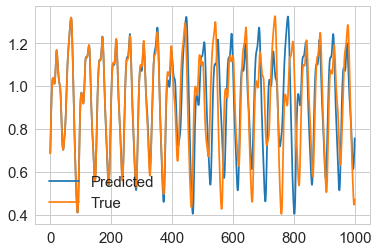

Took 8.609664 seconds.
NRMSE: 0.509123


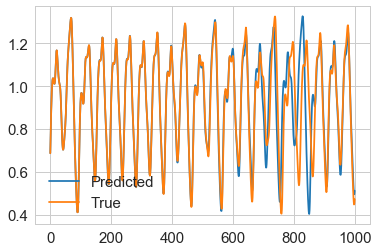

Took 8.539801 seconds.
NRMSE: 1.062583


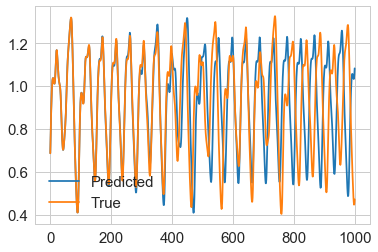

Took 8.708485 seconds.
NRMSE: 0.687297


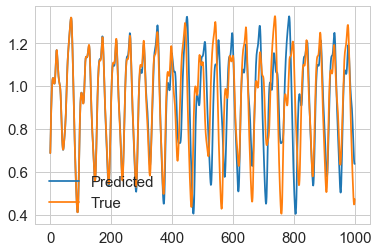

Took 9.081719 seconds.
NRMSE: 0.680623


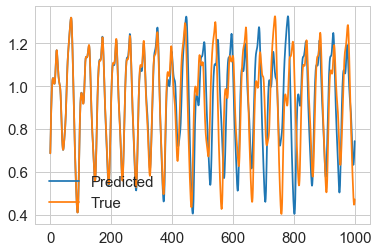

Took 8.715002 seconds.
NRMSE: 0.531293


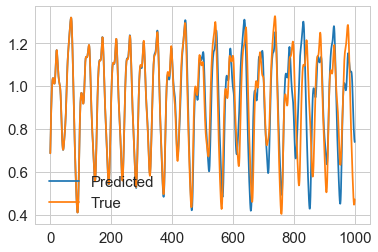

Took 8.764605 seconds.
NRMSE: 0.812240


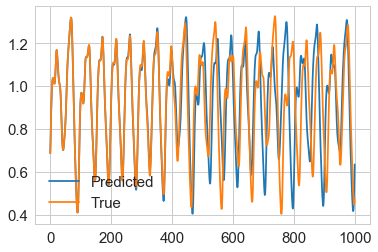

Took 8.536108 seconds.
NRMSE: 0.766592


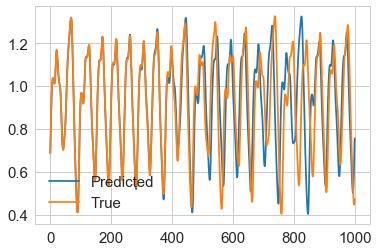

Took 8.703801 seconds.
NRMSE: 0.924000


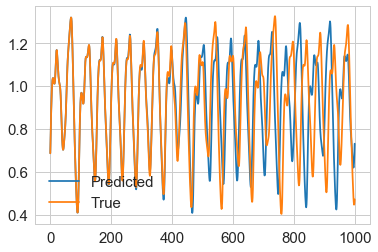

Took 8.710208 seconds.
NRMSE: 0.733702


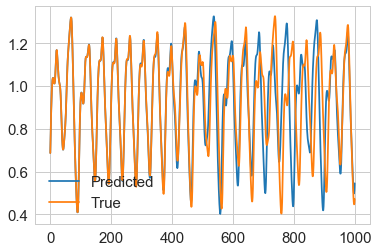

Took 8.548842 seconds.
NRMSE: 0.927713


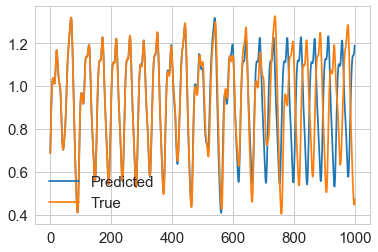

Took 8.591723 seconds.
NRMSE: 0.700162


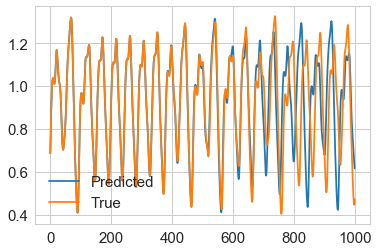

Took 8.621437 seconds.
NRMSE: 0.679459


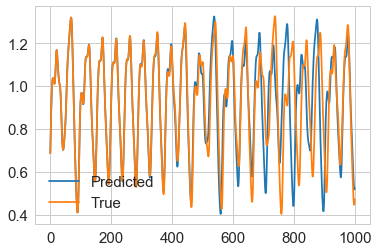

Took 8.974905 seconds.
NRMSE: 0.964669


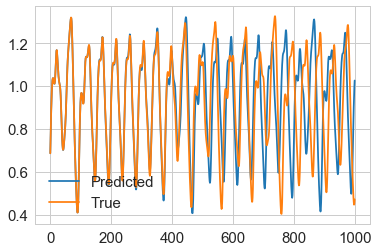

Took 8.728929 seconds.
NRMSE: 0.459701


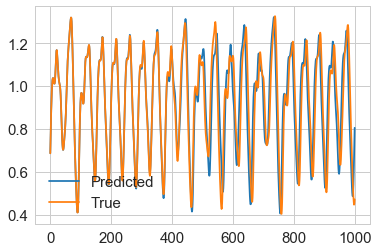

Took 8.649496 seconds.
NRMSE: 0.622579


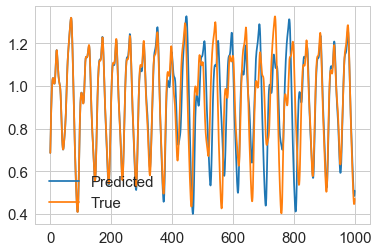

Took 8.439561 seconds.
NRMSE: 0.581270


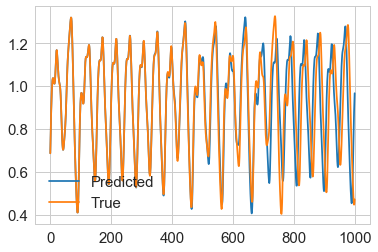

Took 9.228597 seconds.
NRMSE: 0.467204


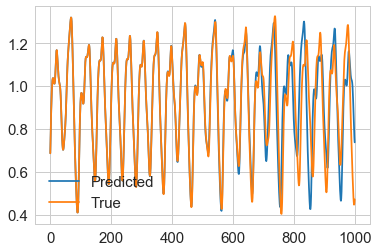

Took 8.482699 seconds.
NRMSE: 0.690820


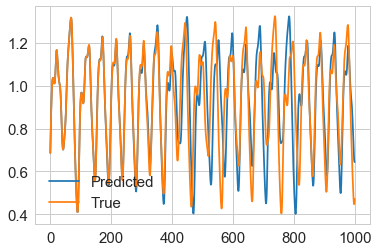

Took 8.312948 seconds.
NRMSE: 0.459458


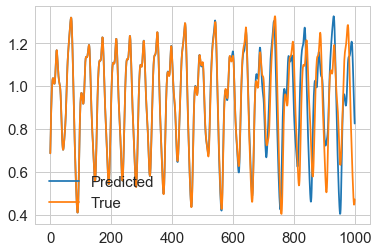

Took 13.646671 seconds.
NRMSE: 0.487236


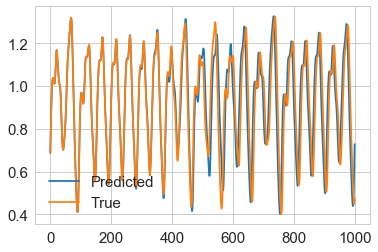

Took 8.510815 seconds.
NRMSE: 0.461804


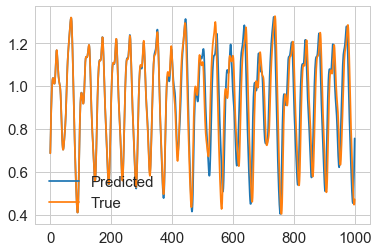

Took 8.818428 seconds.
NRMSE: 0.041933


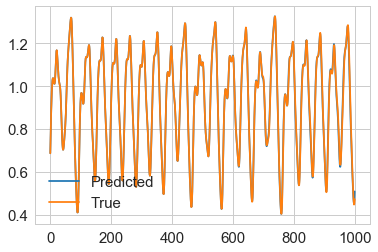

Took 8.725177 seconds.
NRMSE: 0.532739


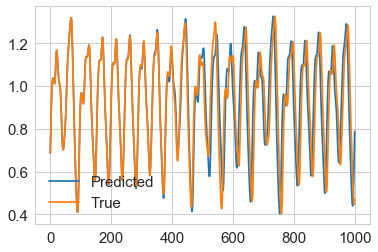

Took 9.198668 seconds.
NRMSE: 0.693742


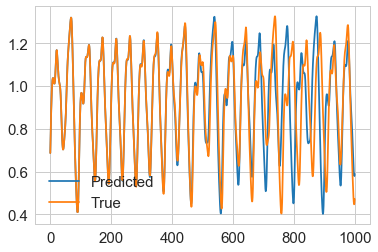

Took 8.436807 seconds.
NRMSE: 0.772559


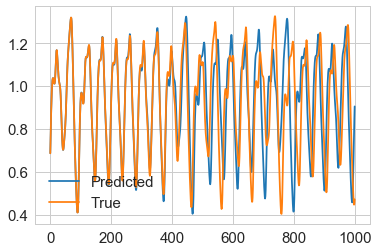

Took 8.656360 seconds.
NRMSE: 0.512800


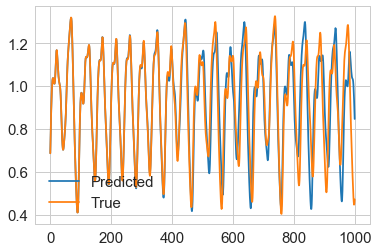

Took 8.526175 seconds.
NRMSE: 0.628763


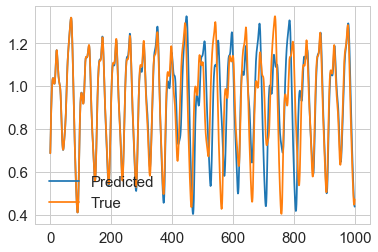

Took 8.392421 seconds.
NRMSE: 0.657839


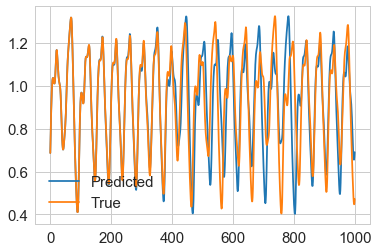

Took 8.459573 seconds.
NRMSE: 0.549753


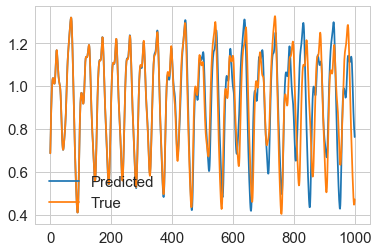

Press enter to save these results.


In [55]:
def run_tests_EESN(n_runs=10, show_plots=False, save=False, test_set=False):
    predics = []
    errors = []
    for _ in range(n_runs):
        
        start_time = time.time()

        model = EESN(
            1, 1, num_reservoirs=10, 
            reservoir_sizes = np.linspace(200, 200, 10).astype(int),
            echo_params=np.linspace(0.5, 0.85, 10),
            regulariser=1e-4
        )
        model.initialize_input_weights(
            scales=np.linspace(0.5, 0.5, 10)
        )
        model.initialize_reservoir_weights(
            spectral_scales=np.linspace(1.25, 1.25, 10)
        )

        model.train(X_train, y_train)
        
        if not test_set:
            y_true = np.array(y_valid)
            y_pred = []
            u_n = np.array(X_valid[0])
            for _ in range(len(y_valid)):
                u_n = np.array(model.forward(u_n))
                y_pred.append(u_n)
        else:
            y_true = np.array(y_test)
            for u_n in X_valid:
                _ = model.forward(u_n)
            
            y_pred = []
            u_n = np.array(X_test[0])
            for _ in range(len(y_test)):
                u_n = np.array(model.forward(u_n))
                y_pred.append(u_n)
                
        print('Took %f seconds.' % (time.time() - start_time))

        y_pred = np.array(y_pred).squeeze()
        predics.append(y_pred)
        
        error = nrmse(y_true, y_pred, data_mean)
        print('NRMSE: %f' % error)
        errors.append(error)
        
        if show_plots:
            xs = range(len(y_pred))
            f, ax = plt.subplots()
            ax.plot(xs, y_pred, label='Predicted')
            
            ax.plot(xs, y_true, label='True')
            plt.legend()
            plt.show()

    to_save = dict()
    to_save[model.info()] = errors

    if save:
        raw_input('Press enter to save these results.')
        title = 'GOOD'+time.asctime()[3:-5].replace(' ', '-')+'.p'
        if USE_NEW_DATA:
            title = 'NEW_DATA_' + title
        if test_set:
            title = 'TEST_SET_' + title
            
        title = 'Results/EESN/' + title
        pkl.dump(to_save, open(title, 'wb'))
    else:
        print('finished')
    
    return errors, predics
    
errors_eesn_test, predics_eesn_test = run_tests_EESN(n_runs=30, show_plots=True, save=True, test_set=True)

# View best ESN grid-search results

In [6]:
res_files = os.listdir('Results/ESN')
#print(res_files)

results = pkl.load(open('Results/ESN/Tue-Mar-20-16:56:03-2018.p'))
results_list = results.items()
print(len(results_list))
results_list = sorted(results_list, key=lambda x: np.max(x[1]))

for k, v in results_list[:3]:
    print(k)
    print(v)
    #raw_input()
    
print(len([(k, v) for (k, v) in results_list if 'e_prm:0.2' not in k]))

1294
r_size:1250
e_prm:0.200000
i_scl:0.200000
s_scl:0.783333
sp:1.000000
reg:0.010000
[0.59374716471616151, 0.63086498194888185, 0.5897664440800624]
r_size:1000
e_prm:0.200000
i_scl:0.200000
s_scl:0.783333
sp:1.000000
reg:0.010000
[0.6052917556094054, 0.6524202603574093, 0.60722586768743891]
r_size:500
e_prm:0.200000
i_scl:0.200000
s_scl:0.900000
sp:1.000000
reg:0.010000
[0.61426149726150781, 0.66452417883158077, 0.59521014896558144]
0


# Run ESN experiments

In [64]:
def run_tests_ESN(n_runs=10, show_plots=False, save=True, test_set=False):
    errors = []
    predics = []
    for _ in range(n_runs):
        start_time = time.time()

        model = ESN(
            1, 1, reservoir_size=1000,
            echo_param=0.85,
            regulariser=1e-5
        )
        model.initialize_input_weights(scale=1.0)
        model.initialize_reservoir_weights(strategy='uniform', spectral_scale=1.25)

        model.train(np.array(X_train), np.array(y_train))

        y_pred = []
        
        if test_set:
            y_true = np.array(y_test)
            
            for u_n in X_valid:
                _ = model.forward(u_n)
                
            u_n = np.array(X_test[0])
            for _ in range(len(y_test)):
                u_n = np.array(model.forward(u_n))
                y_pred.append(u_n)
        else:
            y_true = np.array(y_valid)
            u_n = np.array(X_valid[0])
            for _ in range(len(y_valid)):
                u_n = np.array(model.forward(u_n))
                y_pred.append(u_n)

        print('Took %f seconds.' % (time.time() - start_time))

        y_pred = np.array(y_pred).squeeze()
        predics.append(y_pred)

        error = nrmse(y_true, y_pred, data_mean)
        print('NRMSE: %f' % error)
        errors.append(error)
        
        if show_plots:
            print(len(y_valid), len(y_pred))
            f, ax = plt.subplots()
            xs = range(len(y_pred))
            ax.plot(xs, y_pred, label='Predicted')
            ax.plot(xs, y_true, label='True')
            plt.legend()
            plt.show()

    to_save = dict()
    to_save[model.info()] = errors

    if save:
        raw_input('Press enter to save these results.')
        title = 'GOOD'+time.asctime()[3:-5].replace(' ', '-')+'.p'
        if USE_NEW_DATA:
            title = 'NEW_DATA_' + title
        if test_set:
            title = 'TEST_SET_' + title

        title = 'Results/ESN/' + title
        pkl.dump(to_save, open(title, 'wb'))
    
    return errors, predics
    
errors_esn_test, predics_esn_test = run_tests_ESN(n_runs=30, show_plots=False, save=True, test_set=True)

Took 8.054069 seconds.
NRMSE: 0.896861
Took 8.166584 seconds.
NRMSE: 0.460466
Took 8.304663 seconds.
NRMSE: 1.053314
Took 8.056685 seconds.
NRMSE: 1.018231
Took 8.068075 seconds.
NRMSE: 1.046645
Took 8.228965 seconds.
NRMSE: 0.506567
Took 7.969356 seconds.
NRMSE: 1.001646
Took 9.175991 seconds.
NRMSE: 0.493866
Took 8.523878 seconds.
NRMSE: 0.952521
Took 10.012559 seconds.
NRMSE: 0.571341
Took 13.768092 seconds.
NRMSE: 0.626831
Took 10.114721 seconds.
NRMSE: 0.751982
Took 8.209323 seconds.
NRMSE: 0.874159
Took 8.449029 seconds.
NRMSE: 0.499170
Took 8.232670 seconds.
NRMSE: 1.169377
Took 8.146810 seconds.
NRMSE: 0.524479
Took 8.245836 seconds.
NRMSE: 0.567845
Took 8.503322 seconds.
NRMSE: 40.322466
Took 8.127143 seconds.
NRMSE: 0.658173
Took 8.161965 seconds.
NRMSE: 0.977694
Took 8.291096 seconds.
NRMSE: 0.442237
Took 8.134154 seconds.
NRMSE: 0.767977
Took 8.055020 seconds.
NRMSE: 0.740454
Took 8.603902 seconds.
NRMSE: 0.642293
Took 12.335165 seconds.
NRMSE: 1.047571
Took 8.469388 second

# Create nice histograms here

n_failures: 8


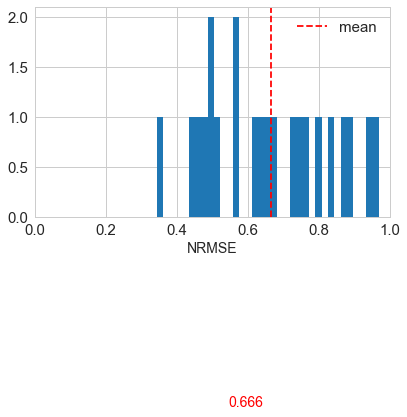

In [65]:
#errors = pkl.load(open('Results/LCESN/GOOD-Mar-22-14:14:05.p', 'rb'))
#errors = errors.values()[0]
errors = np.array(errors_esn_test)
errors_hist = np.array(errors)
errors_hist = errors_hist[np.where(errors_hist <= 1.0)]
mean_error = np.mean(errors_hist)
n_failures = len(errors) - len(errors_hist)
print('n_failures: %d' % n_failures)

hist, bins = np.histogram(errors_hist, bins=35)
bin_width = bins[1] - bins[0]

f, ax = plt.subplots(figsize=(6, 4))
ax.bar(bins[:-1], hist, width=bin_width)
ymin, ymax = ax.get_ylim()
ax.plot(
    [mean_error]*2, [ymin, ymax], linestyle='--', color='red', label='mean'
)
ax.text(
    mean_error-0.12, ymax-4, '%.3f' % mean_error, color='red', fontsize=14
)

ax.set_ylim([ymin, ymax])
ax.set_xlim([0, 1.0])
ax.set_xlabel('NRMSE', fontsize=14)

plt.tight_layout()
plt.legend()
#f.savefig('LCESN-hist-valid.pdf')
plt.show()

# Create nice cumulative error plots here

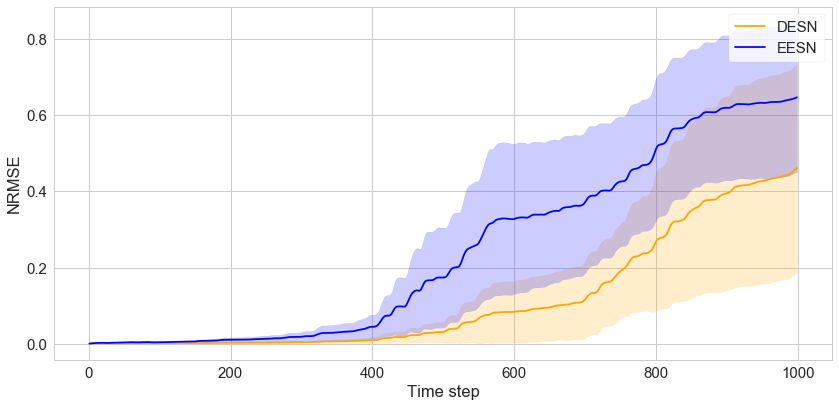

In [63]:
# predics_lcesn = np.array(predics_lcesn).reshape(10, -1)
# predics_esn = np.array(predics_esn).reshape(10, -1)            # these should be shape (10, 1000) 
# predics_eesn = np.array(predics_eesn).reshape(10, -1)

predics_eesn_test = np.array(predics_eesn_test).reshape(30, 1000)
predics_lcesn_test = np.array(predics_lcesn_test).reshape(30, 1000)
predics_esn_test = np.array(predics_esn_test).reshape(30, 1000)

#all_predics = [predics_lcesn, predics_esn, predics_eesn]
all_predics_test = [predics_eesn_test, predics_lcesn_test, predics_esn_test]
labels = ['EESN', 'DESN', 'ESN']
colors = ['blue', 'orange', 'red']
to_plot_errs = []
to_plot_stds = []
for predics, label, color in zip(all_predics_test, labels, colors):
    iter_errors = []
    iter_stds = []
    for i in range(1, len(y_valid)):
        err_is = []
        for j in range(len(predics)):
            err_is.append(nrmse(predics[j, :i], y_test[:i], data_mean))
        err_is = np.array(err_is).reshape(-1, 1)
        iter_errors.append(np.mean(err_is))
        iter_stds.append(np.std(err_is))

    iter_errors, iter_stds = np.array(iter_errors), np.array(iter_stds)
    to_plot_errs.append(iter_errors)
    to_plot_stds.append(iter_stds)

# to_plot_errs and to_plot_stds are lists of np arrays each w/ shape: (999,) 
plot_stuff = zip(to_plot_errs, to_plot_stds, labels, colors)
plot_stuff = sorted(plot_stuff, key=lambda x: np.mean(x[1]))
xs = range(len(y_valid))

f, ax = plt.subplots(figsize=(12, 6))
for errs, stds, label, color in plot_stuff:
    err_plus = errs + stds
    err_minus = errs - stds
    
    ax.plot(xs[1:], errs, label=label, color=color)
    ax.fill_between(xs[1:], err_plus, errs, alpha=0.2, color=color)
    ax.fill_between(xs[1:], errs, np.where(err_minus > 0, err_minus, 0), alpha=0.2, color=color)

ax.set_xlabel('Time step')
ax.set_ylabel('NRMSE')
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

pkl.dump(all_predics, open('FINAL_ERROR_PLOTS_DATA.p', 'wb'))
pkl.dump(all_predics_test, open('FINAL_ERROR_PLOTS_DATA_TEST.p', 'wb'))